# 📝 Text super-resolution
* team name and members: Super-girls, **Agata Żywot 148258, Zuzanna Gawrysiak 148255**
* selected problem and dataset: Super-resolution, [TextZoom](https://paperswithcode.com/dataset/textzoom)

In [1]:
import cv2
import PIL
import numpy as np
from IPython.display import display
import sys
if '../' not in sys.path:
    sys.path.append('../')
import random
import matplotlib.pyplot as plt
%matplotlib inline 

from sklearn.model_selection import train_test_split


import torch
from torch.utils.data import Dataset
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
print("Using torch", torch.__version__)

from src.mdb_to_jpg import mdb_to_jpg
from src.utils import *
from src.data import *
from src.models.srresnet import _NetG, _NetD
from src.models.srgan_train import sr_gan_perform_training
from src.models.srresnet_train import sr_resnet_perform_training
from src.cfg import *

c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


Using torch 1.13.0+cpu


In [3]:
torch.manual_seed(8)
random.seed(8)

if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    device = torch.device("cuda") 
    
else:
    device = torch.device("cpu")

print(f"Using torch { torch.__version__} on {device}")

Using torch 1.13.0+cpu on cpu


In [4]:
torch.cuda.empty_cache()

## Dataset

### Description
Number of images in each subset:
* train: 17367
* test:
    * easy: 1619
    * medium: 1411
    * hard: 1343

In [5]:
# TODO change for train1 at the end since it's > 10000
data_path = 'data/TextZoom/train2_img/'
lmdb_file = 'data/TextZoom/train2'
N = mdb_to_jpg(data_path, lmdb_file)

Number of samples: 2794


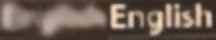

In [6]:
# DISPLAY EXEMPLARY IMAGES
x = 10
imgHR = cv2.imread(data_path+str(x)+'_img_HR.jpg', 1)
imgLR = cv2.imread(data_path+str(x)+'_img_LR.jpg', 1)
show_LR_HR_images(imgLR, imgHR)

In [7]:
# GET HR AND LR images
img_data = get_data_from_dir(data_path, [str(i) for i in range(1, N+1)])

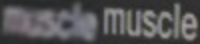

In [8]:
# GET HR AND LR images
data = get_data_from_dir(data_path, [str(i) for i in range(1, N+1)])
x = 1234
show_LR_HR_images(img_data[x][0], img_data[x][1])

### Data preprocessing

In [9]:
LR_images = list(map(lambda x: x[0].shape[:-1], img_data))
HR_images = list(map(lambda x: x[1].shape[:-1], img_data))

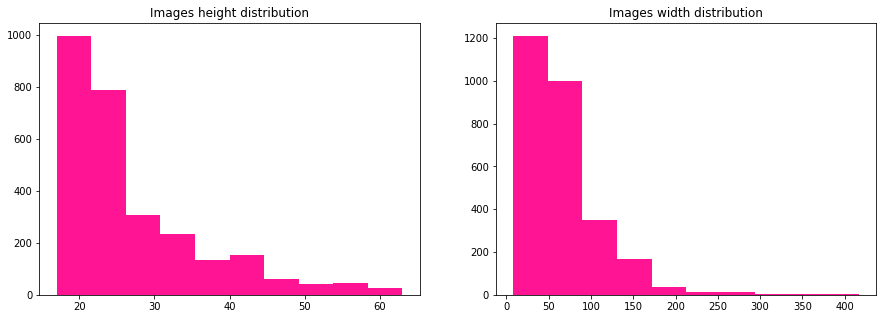

In [10]:
get_height_width_distribution(LR_images)

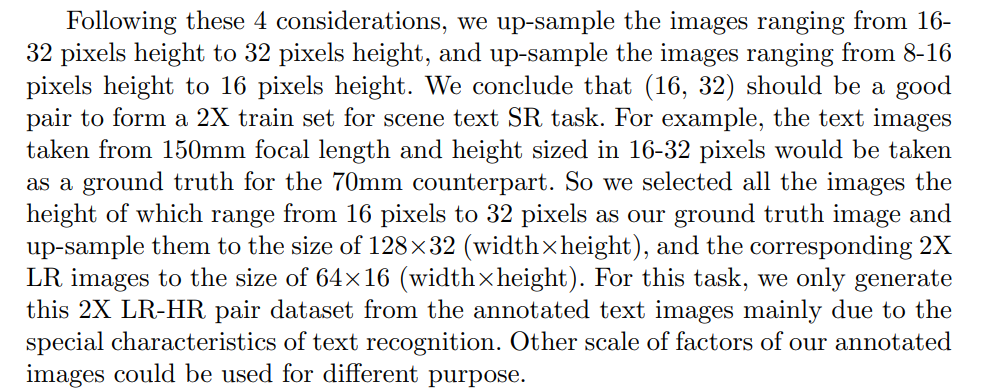<br>
For now I'll just discard the images which height is less than 8 (as they did in paper) and unify the size by padding (but this one should be discussed)

In [11]:
img_data = get_data_from_dir(data_path, [str(i) for i in range(1, N+1)], min_height=8)

In [12]:
# TODO -> replace src.data.SRDataset with the final one
class SRDataset(Dataset):
    def __init__(self, images, crop=True, normalize=True): 
        self.normalize = normalize
        self.crop = crop
        self.images = images

    def __len__(self):
        return len(self.images)

    def preprocess_image(self, image):
        lr = image[0]
        hr = image[1]
        if self.crop:
            lr = cv2.resize(lr, (64, 16))
            hr = cv2.resize(hr, (128, 32))
        if self.normalize:
            # lr = lr / 255 # [0; 1]

            lr = lr.astype(np.float32)
            lr = (lr - 127.5) / 127.5 # [-1; 1]


            hr = hr.astype(np.float32)
            hr = (hr - 127.5) / 127.5 # [-1; 1]

        return torch.tensor(lr).swapaxes(1,2).swapaxes(0,1), torch.tensor(hr).swapaxes(1,2).swapaxes(0,1)

    def __getitem__(self, index):        
        image = self.images[index]         
        return self.preprocess_image(image)

In [13]:
img_data_processed = SRDataset(img_data)

torch.Size([3, 16, 64])

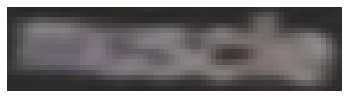

In [14]:
x = 1234
display_img_tensor(img_data_processed[x][0], rescale=True)
img_data_processed[x][0].shape

torch.Size([3, 32, 128])

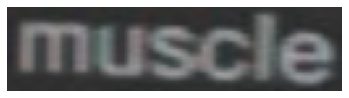

In [15]:
display_img_tensor(img_data_processed[x][1], rescale=True)
img_data_processed[x][1].shape

In [16]:
generator = _NetG()
discriminator = _NetD()

example_batch = torch.stack([img_data_processed[x][0], img_data_processed[1235][0]], dim=0)
print(example_batch.shape)

torch.Size([2, 3, 16, 64])


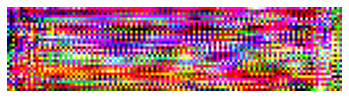

In [17]:
example_SR = generator.forward(example_batch.float())
display_img_tensor(example_SR.detach()[0], rescale=True)

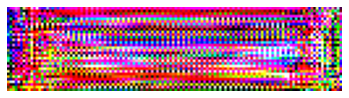

In [18]:
example_SR = generator.forward(example_batch.float())
display_img_tensor(example_SR.detach()[1], rescale=True)

In [19]:
dec = discriminator.forward(example_SR.float())
dec

tensor([[ 0.1692],
        [-0.0041]], grad_fn=<AddmmBackward0>)

In [20]:
train_indices, test_indices = train_test_split(range(N), test_size=0.02)
len(train_indices), len(test_indices)

(2738, 56)

## Models

### SRResNet

In [21]:
train_set = torch.utils.data.Subset(img_data_processed, train_indices)
test_set = torch.utils.data.Subset(img_data_processed, test_indices)

In [22]:
cfg = read_config("cfg/models/srresnet.yaml")
cfg['epochs'] = 5
# cfg['batch_size'] = 16

# sr_gan_perform_training(train_set=train_set, cfg=cfg, run_neptune=False)
sr_resnet_perform_training(train_set=test_set, cfg=cfg, save='blabla')

https://app.neptune.ai/super-girls/Super-Resolution/e/SR-72
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
===> Runs with VGG model support (VGG loss applied)
===> Setting Optimizers
===> Training


Epoch 5: 100%|██████████| 4/4 [00:27<00:00,  6.79s/batch, MSE_loss=1.34, VGG_loss=0.26] 

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 8 operations to synchronize with Neptune. Do not kill this process.
All 8 operations synced, thanks for waiting!


Explore the metadata in the Neptune app:
https://app.neptune.ai/super-girls/Super-Resolution/e/SR-72
Model saved to checkpoint/model_blabla.pth
https://app.neptune.ai/super-girls/Super-Resolution/m/SR-SRRN6/v/SR-SRRN6-8
Remember to stop your model_version once you’ve finished logging your metadata (https://docs.neptune.ai/api/model_version#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/super-girls/Super-Resolution/m/SR-SRRN6/v/SR-SRRN6-8/metadata


In [28]:
cfg = read_config("cfg/models/srresnet.yaml")
cfg['epochs'] = 5
# cfg['batch_size'] = 16

# sr_gan_perform_training(train_set=train_set, cfg=cfg, run_neptune=False)
sr_gan_perform_training(train_set=test_set, cfg=cfg, vgg_loss=False, save='blabla')

https://app.neptune.ai/super-girls/Super-Resolution/e/SR-66
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
===> Runs without VGG (MSE loss applied)
===> Setting Optimizers
===> Training


Epoch 1:   0%|          | 0/4 [00:00<?, ?batch/s]

GENERATOR
content_loss tensor(9.8180, grad_fn=<MseLossBackward0>)
sr_discriminated tensor([[-0.0797],
        [ 0.2299],
        [ 0.0996],
        [-0.1946],
        [-0.3051],
        [-0.1836],
        [ 0.2256],
        [-0.1304],
        [-0.0946],
        [-0.2012],
        [ 0.0576],
        [-0.0121],
        [ 0.0532],
        [-0.1857],
        [ 0.0936],
        [-0.1032]], grad_fn=<AddmmBackward0>)
adversarial_loss 0.7191885709762573
-----------------------------------
DISCRIMINATOR
hr_discriminated tensor([[-0.0818],
        [-0.1952],
        [-0.1232],
        [-0.3333],
        [-0.1758],
        [ 0.0804],
        [-0.0234],
        [-0.1008],
        [-0.0767],
        [-0.2474],
        [ 0.1872],
        [ 0.0666],
        [-0.0026],
        [ 0.0144],
        [-0.0767],
        [ 0.0214]], grad_fn=<AddmmBackward0>)
sr_discriminated tensor([[-0.0797],
        [ 0.2299],
        [ 0.0996],
        [-0.1946],
        [-0.3051],
        [-0.1836],
        [ 0.2256],
  

Epoch 1:  25%|██▌       | 1/4 [00:07<00:21,  7.15s/batch, adversarial_loss=1.4, content_loss_MSE=9.82]

GENERATOR
content_loss tensor(8.3396, grad_fn=<MseLossBackward0>)
sr_discriminated tensor([[-0.3586],
        [-0.2830],
        [-0.4142],
        [-0.0870],
        [-0.1988],
        [ 0.0489],
        [-0.1574],
        [-0.1207],
        [-0.0099],
        [-0.1732],
        [-0.1570],
        [-0.2374],
        [ 0.0642],
        [ 0.2227],
        [-0.1633],
        [-0.3006]], grad_fn=<AddmmBackward0>)
adversarial_loss 0.7716622352600098
-----------------------------------
DISCRIMINATOR
hr_discriminated tensor([[ 0.4695],
        [ 0.2779],
        [ 0.4197],
        [ 0.4811],
        [ 0.3980],
        [-0.0964],
        [-0.1269],
        [ 0.2993],
        [ 0.0144],
        [ 0.4626],
        [ 0.1461],
        [ 0.1139],
        [ 0.0857],
        [-0.0137],
        [ 0.2069],
        [ 0.0364]], grad_fn=<AddmmBackward0>)
sr_discriminated tensor([[-0.3586],
        [-0.2830],
        [-0.4142],
        [-0.0870],
        [-0.1988],
        [ 0.0489],
        [-0.1574],
  

Epoch 1:  50%|█████     | 2/4 [00:12<00:12,  6.25s/batch, adversarial_loss=1.23, content_loss_MSE=8.34]

GENERATOR
content_loss tensor(7.1132, grad_fn=<MseLossBackward0>)
sr_discriminated tensor([[-0.3697],
        [ 0.0738],
        [-0.4075],
        [-0.3896],
        [-0.3916],
        [-0.7584],
        [-0.6171],
        [-0.0274],
        [-0.7863],
        [-0.5210],
        [-0.4398],
        [-0.2559],
        [-0.4756],
        [-0.5918],
        [-0.6173],
        [-0.7359]], grad_fn=<AddmmBackward0>)
adversarial_loss 0.9540441632270813
-----------------------------------
DISCRIMINATOR
hr_discriminated tensor([[ 0.2027],
        [ 0.5369],
        [-0.0036],
        [-0.1074],
        [-0.0952],
        [ 0.7345],
        [ 0.5510],
        [-0.3274],
        [ 0.6064],
        [ 0.2966],
        [ 0.3253],
        [-0.0642],
        [-0.0586],
        [ 0.6173],
        [ 0.6261],
        [ 0.9775]], grad_fn=<AddmmBackward0>)
sr_discriminated tensor([[-0.3697],
        [ 0.0738],
        [-0.4075],
        [-0.3896],
        [-0.3916],
        [-0.7584],
        [-0.6171],
  

Epoch 1:  75%|███████▌  | 3/4 [00:19<00:06,  6.28s/batch, adversarial_loss=1.07, content_loss_MSE=7.11]

GENERATOR
content_loss tensor(6.0326, grad_fn=<MseLossBackward0>)
sr_discriminated tensor([[-1.0730],
        [-0.7886],
        [-0.2231],
        [-0.6055],
        [-0.5886],
        [-0.7348],
        [-0.1682],
        [-0.7995]], grad_fn=<AddmmBackward0>)
adversarial_loss 1.0613279342651367
-----------------------------------
DISCRIMINATOR
hr_discriminated tensor([[ 1.6754],
        [ 1.1370],
        [ 0.4749],
        [ 0.2937],
        [ 0.5934],
        [ 0.5378],
        [-0.2805],
        [ 1.5959]], grad_fn=<AddmmBackward0>)
sr_discriminated tensor([[-1.0730],
        [-0.7886],
        [-0.2231],
        [-0.6055],
        [-0.5886],
        [-0.7348],
        [-0.1682],
        [-0.7995]], grad_fn=<AddmmBackward0>)
discriminator losses
sr_predictions 0.4386594891548157
hr_predictions 0.42726925015449524
adversarial_loss 0.8659287691116333


Epoch 2:   0%|          | 0/4 [00:00<?, ?batch/s]

GENERATOR
content_loss tensor(5.0848, grad_fn=<MseLossBackward0>)
sr_discriminated tensor([[-0.7739],
        [-1.7163],
        [-1.7399],
        [-1.2864],
        [-1.9491],
        [-1.2165],
        [-1.1492],
        [-1.5596],
        [-1.9728],
        [-1.7580],
        [-1.8091],
        [-1.8928],
        [-1.8869],
        [-1.8647],
        [-1.4072],
        [-1.1948]], grad_fn=<AddmmBackward0>)
adversarial_loss 1.7709980010986328
-----------------------------------
DISCRIMINATOR
hr_discriminated tensor([[1.8353],
        [2.0909],
        [3.5590],
        [3.7197],
        [2.2830],
        [1.2021],
        [1.8390],
        [4.8873],
        [2.1303],
        [2.2661],
        [3.4763],
        [4.9822],
        [1.5010],
        [1.8790],
        [2.1970],
        [2.0162]], grad_fn=<AddmmBackward0>)
sr_discriminated tensor([[-0.7739],
        [-1.7163],
        [-1.7399],
        [-1.2864],
        [-1.9491],
        [-1.2165],
        [-1.1492],
        [-1.5596],

Epoch 2:  25%|██▌       | 1/4 [00:05<00:16,  5.47s/batch, adversarial_loss=0.301, content_loss_MSE=5.08]

GENERATOR
content_loss tensor(4.9108, grad_fn=<MseLossBackward0>)
sr_discriminated tensor([[-2.0845],
        [-2.1094],
        [-1.4151],
        [-2.5058],
        [-1.7657],
        [-2.4491],
        [-1.3111],
        [-2.2793],
        [-1.2270],
        [-1.8968],
        [-1.6595],
        [-1.1919],
        [-3.2306],
        [-2.3611],
        [-1.7346],
        [-1.7562]], grad_fn=<AddmmBackward0>)
adversarial_loss 2.0855722427368164
-----------------------------------
DISCRIMINATOR
hr_discriminated tensor([[3.4045],
        [3.4271],
        [2.9865],
        [3.7331],
        [2.7557],
        [1.5690],
        [2.2056],
        [1.8101],
        [1.2865],
        [3.5670],
        [1.9154],
        [0.8739],
        [1.6522],
        [1.1839],
        [2.8253],
        [3.3674]], grad_fn=<AddmmBackward0>)
sr_discriminated tensor([[-2.0845],
        [-2.1094],
        [-1.4151],
        [-2.5058],
        [-1.7657],
        [-2.4491],
        [-1.3111],
        [-2.2793],

Epoch 2:  50%|█████     | 2/4 [00:10<00:10,  5.45s/batch, adversarial_loss=0.27, content_loss_MSE=4.91] 

GENERATOR
content_loss tensor(4.3824, grad_fn=<MseLossBackward0>)
sr_discriminated tensor([[-2.0076],
        [-3.2679],
        [-1.6990],
        [-2.9565],
        [-2.9031],
        [-2.3166],
        [-2.2298],
        [-2.4333],
        [-2.5632],
        [-2.2123],
        [-2.2140],
        [-2.0783],
        [-2.5942],
        [-1.8957],
        [-2.0187],
        [-1.7696]], grad_fn=<AddmmBackward0>)
adversarial_loss 2.4230828285217285
-----------------------------------
DISCRIMINATOR
hr_discriminated tensor([[0.9370],
        [1.7491],
        [1.4192],
        [1.1607],
        [1.1689],
        [3.8923],
        [3.6120],
        [0.7267],
        [2.6341],
        [2.0302],
        [3.4735],
        [1.1196],
        [1.5573],
        [2.8479],
        [2.8487],
        [3.8751]], grad_fn=<AddmmBackward0>)
sr_discriminated tensor([[-2.0076],
        [-3.2679],
        [-1.6990],
        [-2.9565],
        [-2.9031],
        [-2.3166],
        [-2.2298],
        [-2.4333],

Epoch 2:  75%|███████▌  | 3/4 [00:16<00:05,  5.29s/batch, adversarial_loss=0.258, content_loss_MSE=4.38]

GENERATOR
content_loss tensor(4.0274, grad_fn=<MseLossBackward0>)
sr_discriminated tensor([[-1.4759],
        [-1.4566],
        [-3.0301],
        [-2.9507],
        [-3.3113],
        [-2.4609],
        [-3.7927],
        [-1.2900]], grad_fn=<AddmmBackward0>)
adversarial_loss 2.5831058025360107
-----------------------------------
DISCRIMINATOR
hr_discriminated tensor([[4.5288],
        [3.8332],
        [2.4129],
        [3.6146],
        [2.7982],
        [3.5961],
        [4.9926],
        [4.5429]], grad_fn=<AddmmBackward0>)
sr_discriminated tensor([[-1.4759],
        [-1.4566],
        [-3.0301],
        [-2.9507],
        [-3.3113],
        [-2.4609],
        [-3.7927],
        [-1.2900]], grad_fn=<AddmmBackward0>)
discriminator losses
sr_predictions 0.11208312958478928
hr_predictions 0.031004082411527634
adversarial_loss 0.1430872082710266


Epoch 3:   0%|          | 0/4 [00:00<?, ?batch/s]

GENERATOR
content_loss tensor(3.7738, grad_fn=<MseLossBackward0>)
sr_discriminated tensor([[-3.3458],
        [-6.2414],
        [-3.5564],
        [-2.0039],
        [-4.3054],
        [-4.3457],
        [-3.2140],
        [-1.4335],
        [-2.4649],
        [-5.4720],
        [-1.9023],
        [-2.2522],
        [-2.3860],
        [-2.4279],
        [-3.7877],
        [-2.5981]], grad_fn=<AddmmBackward0>)
adversarial_loss 3.2999768257141113
-----------------------------------
DISCRIMINATOR
hr_discriminated tensor([[1.6621],
        [3.0749],
        [3.4734],
        [5.7223],
        [1.8539],
        [0.9730],
        [2.2089],
        [4.2864],
        [3.0170],
        [3.0993],
        [5.6024],
        [6.4654],
        [2.9795],
        [3.3442],
        [2.6838],
        [1.9415]], grad_fn=<AddmmBackward0>)
sr_discriminated tensor([[-3.3458],
        [-6.2414],
        [-3.5564],
        [-2.0039],
        [-4.3054],
        [-4.3457],
        [-3.2140],
        [-1.4335],

Epoch 3:  25%|██▌       | 1/4 [00:04<00:12,  4.15s/batch, adversarial_loss=0.143, content_loss_MSE=3.77]

GENERATOR
content_loss tensor(3.9360, grad_fn=<MseLossBackward0>)
sr_discriminated tensor([[-2.1134],
        [-2.8258],
        [-2.2659],
        [-3.9028],
        [-2.5014],
        [-4.8071],
        [-4.3793],
        [-4.9500],
        [-4.1862],
        [-3.8043],
        [-2.1340],
        [-3.1014],
        [-6.4629],
        [-5.3304],
        [-2.4392],
        [-3.5012]], grad_fn=<AddmmBackward0>)
adversarial_loss 3.713432788848877
-----------------------------------
DISCRIMINATOR
hr_discriminated tensor([[ 4.3293],
        [ 4.6433],
        [ 4.8715],
        [-1.2810],
        [ 4.4960],
        [ 1.9702],
        [ 3.1316],
        [ 2.3056],
        [ 2.6400],
        [ 4.7663],
        [ 2.8588],
        [ 2.2227],
        [ 2.2856],
        [ 2.1740],
        [ 3.2129],
        [ 3.2373]], grad_fn=<AddmmBackward0>)
sr_discriminated tensor([[-2.1134],
        [-2.8258],
        [-2.2659],
        [-3.9028],
        [-2.5014],
        [-4.8071],
        [-4.3793],
   

Epoch 3:  50%|█████     | 2/4 [00:08<00:08,  4.36s/batch, adversarial_loss=0.191, content_loss_MSE=3.94]

GENERATOR
content_loss tensor(3.7951, grad_fn=<MseLossBackward0>)
sr_discriminated tensor([[-3.5980],
        [-4.7173],
        [-2.7899],
        [-5.0840],
        [-3.6346],
        [-2.1830],
        [-3.4450],
        [-3.4494],
        [-3.4928],
        [-2.5164],
        [-2.6919],
        [-3.0405],
        [-4.8506],
        [-2.3383],
        [-2.9265],
        [-1.3011]], grad_fn=<AddmmBackward0>)
adversarial_loss 3.3105897903442383
-----------------------------------
DISCRIMINATOR
hr_discriminated tensor([[2.5178],
        [3.2933],
        [2.4000],
        [3.0084],
        [2.8949],
        [4.5986],
        [4.3714],
        [2.7978],
        [3.7408],
        [3.7722],
        [4.3130],
        [2.8250],
        [3.2286],
        [4.2498],
        [4.2877],
        [6.1770]], grad_fn=<AddmmBackward0>)
sr_discriminated tensor([[-3.5980],
        [-4.7173],
        [-2.7899],
        [-5.0840],
        [-3.6346],
        [-2.1830],
        [-3.4450],
        [-3.4494],

Epoch 3:  75%|███████▌  | 3/4 [00:13<00:04,  4.67s/batch, adversarial_loss=0.0925, content_loss_MSE=3.8]

GENERATOR
content_loss tensor(3.6909, grad_fn=<MseLossBackward0>)
sr_discriminated tensor([[-2.5679],
        [-2.9700],
        [-5.3372],
        [-2.6975],
        [-3.0715],
        [-3.3143],
        [-4.2203],
        [-1.8439]], grad_fn=<AddmmBackward0>)
adversarial_loss 3.307358503341675
-----------------------------------
DISCRIMINATOR
hr_discriminated tensor([[5.3374],
        [5.9101],
        [4.8380],
        [5.6200],
        [4.8777],
        [5.4910],
        [7.6337],
        [6.0953]], grad_fn=<AddmmBackward0>)
sr_discriminated tensor([[-2.5679],
        [-2.9700],
        [-5.3372],
        [-2.6975],
        [-3.0715],
        [-3.3143],
        [-4.2203],
        [-1.8439]], grad_fn=<AddmmBackward0>)
discriminator losses
sr_predictions 0.05455130338668823
hr_predictions 0.004181270953267813
adversarial_loss 0.05873257294297218


Epoch 4:   0%|          | 0/4 [00:00<?, ?batch/s]

GENERATOR
content_loss tensor(3.4621, grad_fn=<MseLossBackward0>)
sr_discriminated tensor([[-5.5064],
        [-6.9727],
        [-2.3820],
        [-3.3048],
        [-4.2529],
        [-5.1124],
        [-4.0019],
        [-2.9698],
        [-3.4683],
        [-5.1029],
        [-4.0735],
        [-3.2391],
        [-4.0551],
        [-3.1695],
        [-3.3152],
        [-4.8615]], grad_fn=<AddmmBackward0>)
adversarial_loss 4.1374640464782715
-----------------------------------
DISCRIMINATOR
hr_discriminated tensor([[3.8399],
        [4.6216],
        [4.2864],
        [7.3780],
        [2.5312],
        [2.6072],
        [3.7056],
        [5.0126],
        [3.7146],
        [3.9056],
        [5.9725],
        [7.1706],
        [4.4572],
        [4.6428],
        [4.0374],
        [3.3443]], grad_fn=<AddmmBackward0>)
sr_discriminated tensor([[-5.5064],
        [-6.9727],
        [-2.3820],
        [-3.3048],
        [-4.2529],
        [-5.1124],
        [-4.0019],
        [-2.9698],

Epoch 4:  25%|██▌       | 1/4 [00:03<00:11,  3.86s/batch, adversarial_loss=0.0473, content_loss_MSE=3.46]

GENERATOR
content_loss tensor(3.7145, grad_fn=<MseLossBackward0>)
sr_discriminated tensor([[-5.3186],
        [-4.8916],
        [-3.1579],
        [-4.1326],
        [-4.8006],
        [-5.1635],
        [-5.7330],
        [-4.7135],
        [-5.5754],
        [-4.7061],
        [-3.4511],
        [-3.7536],
        [-6.2601],
        [-6.5370],
        [-2.6947],
        [-6.1382]], grad_fn=<AddmmBackward0>)
adversarial_loss 4.828848838806152
-----------------------------------
DISCRIMINATOR
hr_discriminated tensor([[4.5330],
        [4.6032],
        [5.6848],
        [9.5286],
        [4.6801],
        [4.8675],
        [4.6798],
        [3.2882],
        [4.4581],
        [5.0350],
        [3.7336],
        [4.0357],
        [3.5976],
        [3.7348],
        [3.5605],
        [2.2628]], grad_fn=<AddmmBackward0>)
sr_discriminated tensor([[-5.3186],
        [-4.8916],
        [-3.1579],
        [-4.1326],
        [-4.8006],
        [-5.1635],
        [-5.7330],
        [-4.7135],


Epoch 4:  50%|█████     | 2/4 [00:08<00:08,  4.12s/batch, adversarial_loss=0.0349, content_loss_MSE=3.71]

GENERATOR
content_loss tensor(3.7007, grad_fn=<MseLossBackward0>)
sr_discriminated tensor([[-4.2781],
        [-4.2863],
        [-5.5921],
        [-7.4399],
        [-3.1427],
        [-5.0046],
        [-5.2251],
        [-2.8841],
        [-5.7551],
        [-5.1227],
        [-3.7798],
        [-5.3757],
        [-5.3539],
        [-4.9946],
        [-4.8753],
        [-3.3833]], grad_fn=<AddmmBackward0>)
adversarial_loss 4.7951507568359375
-----------------------------------
DISCRIMINATOR
hr_discriminated tensor([[4.1433],
        [4.3915],
        [3.6594],
        [4.5164],
        [4.6397],
        [4.5175],
        [4.5911],
        [4.7052],
        [3.3535],
        [4.5221],
        [5.7188],
        [4.2997],
        [4.9382],
        [4.2883],
        [4.3998],
        [6.3357]], grad_fn=<AddmmBackward0>)
sr_discriminated tensor([[-4.2781],
        [-4.2863],
        [-5.5921],
        [-7.4399],
        [-3.1427],
        [-5.0046],
        [-5.2251],
        [-2.8841],

Epoch 4:  75%|███████▌  | 3/4 [00:13<00:04,  4.50s/batch, adversarial_loss=0.0269, content_loss_MSE=3.7] 

GENERATOR
content_loss tensor(3.6600, grad_fn=<MseLossBackward0>)
sr_discriminated tensor([[-4.5865],
        [-3.6781],
        [-6.5666],
        [-3.6264],
        [-3.8893],
        [-3.4726],
        [-7.4116],
        [-4.9417]], grad_fn=<AddmmBackward0>)
adversarial_loss 4.786761283874512
-----------------------------------
DISCRIMINATOR
hr_discriminated tensor([[4.2233],
        [6.9238],
        [6.7544],
        [6.1357],
        [6.2578],
        [6.2279],
        [8.5457],
        [6.1541]], grad_fn=<AddmmBackward0>)
sr_discriminated tensor([[-4.5865],
        [-3.6781],
        [-6.5666],
        [-3.6264],
        [-3.8893],
        [-3.4726],
        [-7.4116],
        [-4.9417]], grad_fn=<AddmmBackward0>)
discriminator losses
sr_predictions 0.015162769705057144
hr_predictions 0.003132109995931387
adversarial_loss 0.01829488016664982


Epoch 5:   0%|          | 0/4 [00:00<?, ?batch/s]

GENERATOR
content_loss tensor(3.4448, grad_fn=<MseLossBackward0>)
sr_discriminated tensor([[-7.4988],
        [-7.4790],
        [-2.0751],
        [-4.0583],
        [-5.9717],
        [-7.9385],
        [-5.0209],
        [-3.2315],
        [-4.6762],
        [-7.0784],
        [-3.2929],
        [-4.2985],
        [-5.2546],
        [-4.9541],
        [-5.4495],
        [-6.6289]], grad_fn=<AddmmBackward0>)
adversarial_loss 5.323094844818115
-----------------------------------
DISCRIMINATOR
hr_discriminated tensor([[5.1902],
        [5.5177],
        [3.8882],
        [7.9897],
        [3.7962],
        [3.7775],
        [4.6653],
        [4.4355],
        [3.8628],
        [4.2485],
        [5.1749],
        [6.2319],
        [5.3108],
        [5.2048],
        [4.5403],
        [4.3755]], grad_fn=<AddmmBackward0>)
sr_discriminated tensor([[-7.4988],
        [-7.4790],
        [-2.0751],
        [-4.0583],
        [-5.9717],
        [-7.9385],
        [-5.0209],
        [-3.2315],


Epoch 5:  25%|██▌       | 1/4 [00:05<00:15,  5.23s/batch, adversarial_loss=0.0272, content_loss_MSE=3.44]

GENERATOR
content_loss tensor(3.7466, grad_fn=<MseLossBackward0>)
sr_discriminated tensor([[-2.1549],
        [-4.2525],
        [-1.9403],
        [-4.4301],
        [-2.2252],
        [-6.8309],
        [-7.5441],
        [-5.0637],
        [-6.3649],
        [-4.9949],
        [-4.8681],
        [-6.0284],
        [-5.6298],
        [-7.0078],
        [-3.2307],
        [-5.0469]], grad_fn=<AddmmBackward0>)
adversarial_loss 4.878856182098389
-----------------------------------
DISCRIMINATOR
hr_discriminated tensor([[ 3.8110],
        [ 4.2261],
        [ 5.5086],
        [12.8872],
        [ 4.5873],
        [ 6.0412],
        [ 4.9418],
        [ 4.0977],
        [ 5.0709],
        [ 4.9818],
        [ 4.1050],
        [ 5.2245],
        [ 4.7495],
        [ 4.5831],
        [ 2.5559],
        [ 3.0515]], grad_fn=<AddmmBackward0>)
sr_discriminated tensor([[-2.1549],
        [-4.2525],
        [-1.9403],
        [-4.4301],
        [-2.2252],
        [-6.8309],
        [-7.5441],
   

Epoch 5:  50%|█████     | 2/4 [00:10<00:10,  5.00s/batch, adversarial_loss=0.0437, content_loss_MSE=3.75]

GENERATOR
content_loss tensor(3.7683, grad_fn=<MseLossBackward0>)
sr_discriminated tensor([[-5.9242],
        [-6.8937],
        [-6.0767],
        [-8.8370],
        [-4.7000],
        [-2.9322],
        [-5.2433],
        [-3.0571],
        [-3.9405],
        [-4.6910],
        [-3.5613],
        [-6.6945],
        [-6.8697],
        [-3.3172],
        [-4.7392],
        [-0.3458]], grad_fn=<AddmmBackward0>)
adversarial_loss 4.91123104095459
-----------------------------------
DISCRIMINATOR
hr_discriminated tensor([[5.0545],
        [5.5588],
        [4.1050],
        [4.9875],
        [5.2137],
        [3.3136],
        [5.4151],
        [5.6617],
        [3.7168],
        [4.8016],
        [5.3687],
        [5.3780],
        [5.9388],
        [3.9362],
        [4.2040],
        [5.9847]], grad_fn=<AddmmBackward0>)
sr_discriminated tensor([[-5.9242],
        [-6.8937],
        [-6.0767],
        [-8.8370],
        [-4.7000],
        [-2.9322],
        [-5.2433],
        [-3.0571],
 

Epoch 5:  75%|███████▌  | 3/4 [00:15<00:05,  5.01s/batch, adversarial_loss=0.0575, content_loss_MSE=3.77]

GENERATOR
content_loss tensor(3.6431, grad_fn=<MseLossBackward0>)
sr_discriminated tensor([[-3.7247],
        [-3.1880],
        [-6.8587],
        [-7.4517],
        [-4.5342],
        [-6.5194],
        [-9.0565],
        [-6.8850]], grad_fn=<AddmmBackward0>)
adversarial_loss 6.037174224853516
-----------------------------------
DISCRIMINATOR
hr_discriminated tensor([[2.2205],
        [7.2189],
        [7.9454],
        [5.5194],
        [6.7763],
        [5.8109],
        [8.0944],
        [5.6674]], grad_fn=<AddmmBackward0>)
sr_discriminated tensor([[-3.7247],
        [-3.1880],
        [-6.8587],
        [-7.4517],
        [-4.5342],
        [-6.5194],
        [-9.0565],
        [-6.8850]], grad_fn=<AddmmBackward0>)
discriminator losses
sr_predictions 0.009897315874695778
hr_predictions 0.014503284357488155
adversarial_loss 0.02440059930086136


Epoch 5: 100%|██████████| 4/4 [00:17<00:00,  4.45s/batch, adversarial_loss=0.0244, content_loss_MSE=3.64]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 75 operations to synchronize with Neptune. Do not kill this process.


All 75 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/super-girls/Super-Resolution/e/SR-66
Model saved to checkpoint/model_blabla.pth
https://app.neptune.ai/super-girls/Super-Resolution/m/SR-SRRN6/v/SR-SRRN6-5
Remember to stop your model_version once you’ve finished logging your metadata (https://docs.neptune.ai/api/model_version#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/super-girls/Super-Resolution/m/SR-SRRN6/v/SR-SRRN6-5/metadata


### Exemplary predictions

In [28]:
# TODO show sample predictions

In [23]:
checkpoint = torch.load('checkpoint/model_blabla.pth', map_location=torch.device('cpu'))
new_model = checkpoint['model']

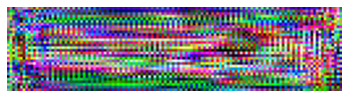

In [24]:
new_model.eval()
LR_res = new_model.forward(example_batch.float())
display_img_tensor(LR_res.detach()[0], rescale=True)

### Text Gestalt

The next tested model is based on the paper ["Text Gestalt: Stroke-Aware Scene Text Image Super-Resolution"](https://arxiv.org/pdf/2112.08171v1.pdf). We used code available at [GitHub](https://github.com/FudanVI/FudanOCR/tree/main/text-gestalt) and trained the net architecture from scratch.

The model is inspired by Gestalt Psychology, which states that humans can construct the complete appearance of object with the guidance of local details. Therefore English characters can be decomposed as follows:

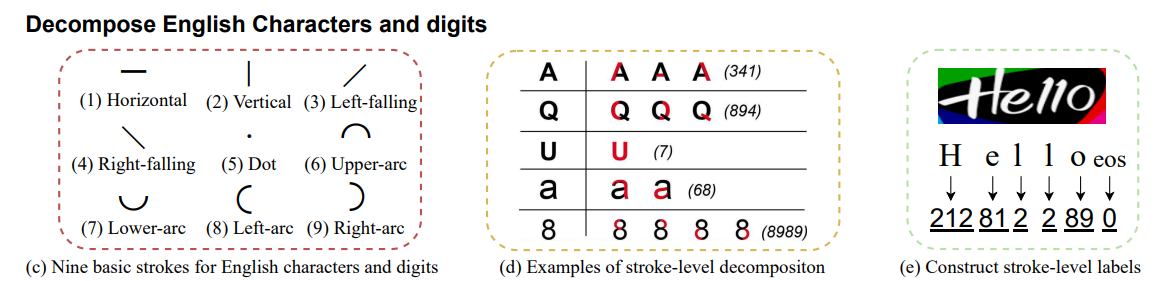
#### Overall architecture
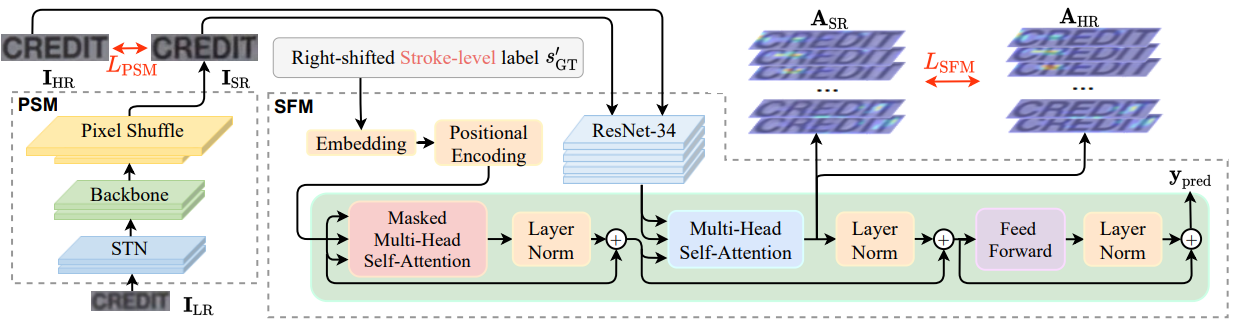

It is worth noticining that the model uses [Multi-Head Self-Attention](https://arxiv.org/pdf/1706.03762v5.pdf) to generate stroke-level maps.
#### Model analysis
* size: 10.3MB
* number of parameters: 2671020
* used metrics: 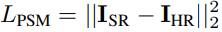
#### Learning curves

#### Sample images